# Jupiter in Jupyter
### Smoothed Particle Hydrodynamics and Gas Giant Equilibrium 

Sai Chikine & Alex Rybchuk

Advisor: Professor Yecko

Ph 235

# Introduction - SPH


# What is it?

* Particle-based method of solving hydrodynamic equations
* Advantages over grid-based code:
    * No need to deal with extensive grid-refinement
    * Deals well with nearly empty regions (eg: space between galaxies)
    * Better at dealing with problems which lack symmetries

# How does it work?
\begin{equation}
\frac{dv_i}{dt} = -\frac{1}{\rho_i}\nabla P_i - \nabla \Phi_i
\end{equation}

* The crux of SPH lies in this equation
    * The driving question in SPH - how do you calculate density at a point?
    
\begin{equation}
\rho_j(r) = m_j W(|r-r_j|,h)
\end{equation}

# Our Project - Equilibrium of Jupiter

* A gas giant collision is a good candidate for SPH
    * Collisions lack a clear symmetry
* Pressure can be modeled using a simple polytrope relation $P = K\rho^\gamma$

In [11]:
# Imports

%matplotlib inline

from __future__ import division

import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.collections import PatchCollection
from scipy.spatial.distance import cdist

from ipywidgets import interact, HTML, FloatSlider
from IPython.display import clear_output, display

import numba as nb
import time

In [12]:
# Model constants

RJupiter = 6.99e9                 # radius of Jupiter, cm
mJupiter = 1.898e30               # mass of Jupiter, grams
v = 1e-3                          # damping coefficient
gamma = 2                         # polytrope index
G = 6.67e-8                       # dyne*cm^2/g^2
rhoC = 5                          # g/cm^3, central density
K = 2.6e12*5                        # dyne*cm^4/g^2
h = 2.5e9                         # smoothing length
gravCutoff = 1e8                  # Below this distance, gravity is 0 (to prevent singularities)
#N1 = 50                          # Particles in planet 1

# Position, Velocity, and Mass Intialization

* [Textbook](https://github.com/ribby/Jupiter_SPH/blob/master/NumericalMethodsInAstrophysics.pdf) provides an equation to initialize positions for a normalized coordinate system
* Our implementation didn't provide sensible results, so we went with a Gaussian distribution instead

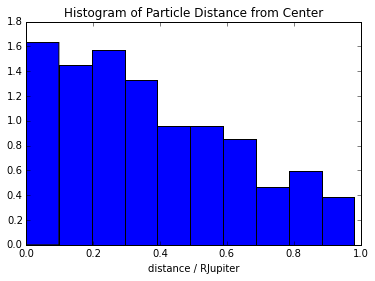

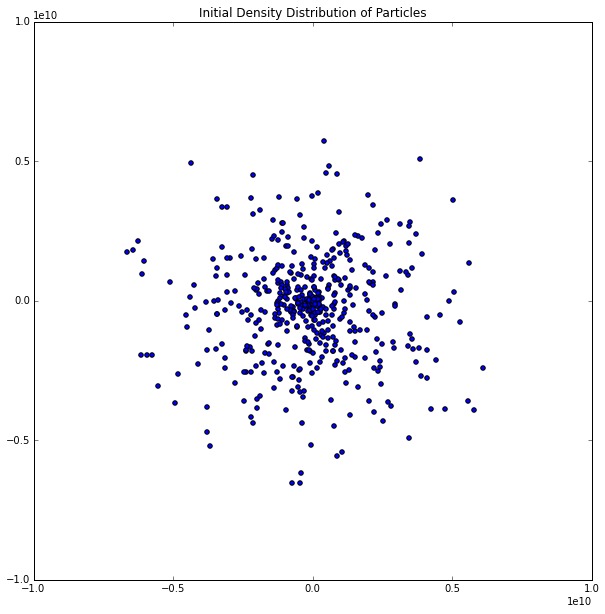

In [13]:
nParticles = 500

# Truncated normal distribution of particles
lower, upper = 0, 1
mu, sigma = 0, 0.5
X = stats.truncnorm(
    (lower - mu) / sigma, (upper - mu) / sigma, loc=mu, scale=sigma)

# Plot histogram
plt.hist(X.rvs(nParticles), normed=True)
plt.title('Histogram of Particle Distance from Center')
plt.xlabel('distance / RJupiter')

# Initialize coordinates
radiusDistribution = X.rvs(nParticles) * RJupiter
thetaDistribution = np.random.uniform(0, 2*np.pi, size=nParticles)

# Plot particles
plt.figure(figsize=(10,10))
plt.scatter(radiusDistribution*np.cos(thetaDistribution), \
            radiusDistribution*np.sin(thetaDistribution))
plt.title("Initial Density Distribution of Particles")
plt.xlim(-1e10,1e10)
plt.ylim(-1e10,1e10)
plt.plot()

# Convert to Cartesian Position
def polar2cart(r, theta):
    return np.array([r*np.cos(theta), r*np.sin(theta)]).T

xyDistribution = polar2cart(radiusDistribution, thetaDistribution)

# Velocity and mass initialization
velocityDistribution = np.zeros_like(xyDistribution)
mDistribution = np.ones(nParticles)*mJupiter/nParticles

# Smoothing Kernel and Density Updates

In [14]:
def W(dist, h):
    '''
    Inputs:
        dist: a scalar distance between particles i an j
        h: smoothing length
    '''
    if dist < h:
        return 1/(np.pi*h**3) * \
               (1/4*(2-dist/h)**3 - (1-dist/h)**3)
    elif dist > 2 * h:
        return 0
    else:
        return 1/(np.pi*h**3) * (1/4*(2-dist/h)**3)

In [15]:
def gradW(xyDist, h):
    '''
    Inputs:
        xyDist: a [2,1] array containing the difference in [x,y] position
            between two particles
        h: smoothing length
    Outputs:
        a [2,1] array containing the [x,y] component of gradW
    '''
    
    dist = np.sqrt(xyDist[0]**2 + xyDist[1]**2)
    
    if dist < h:
        return np.array(
                [3*xyDist[0]*(3*dist - 4*h)/(4*np.pi*h**6),
                 3*xyDist[1]*(3*dist - 4*h)/(4*np.pi*h**6)])
    
    elif dist > 2 * h:
        return np.array([0,0])
    
    else:
        return np.array(
                [-3*xyDist[0]*(-2*h+dist)**2/(4*h**6*np.pi*dist),
                 -3*xyDist[1]*(-2*h+dist)**2/(4*h**6*np.pi*dist)])

In [16]:
def densityUpdate():
    '''
    Updates global density
    '''
    global xyDistribution
    global rhoDistribution
    global mDistribution

    rhoDistribution = np.zeros_like(rhoDistribution)
    
    for i in range(0, nParticles):
        
        # Density contribution from other particles
        for j in range(i, nParticles):
            xdist = (xyDistribution[i,0]-xyDistribution[j,0])
            ydist = (xyDistribution[i,1]-xyDistribution[j,1])
            dist_ij = np.sqrt(xdist**2 + ydist**2)
            rho_ij = mDistribution[i]*W(dist_ij, h)
            
            # Symmetric nature of density contributions
            rhoDistribution[i] += rho_ij / 2    # Double counting densities
            rhoDistribution[j] += rho_ij / 2    

# Pressure Force

In [17]:
def gradP():
    
    gradPArray = np.zeros_like(velocityDistribution)

    for i in range(0, nParticles):
        for j in range(i, nParticles):
            
            xdist = (xyDistribution[i,0]-xyDistribution[j,0])
            ydist = (xyDistribution[i,1]-xyDistribution[j,1])
            distArr = np.array([xdist,ydist])
            
            grad = [mDistribution[j]*pressureDistribution[j]/rhoDistribution[j]*gradW(distArr,h)[0], \
                   mDistribution[j]*pressureDistribution[j]/rhoDistribution[j]*gradW(distArr,h)[1]]
        
            gradPArray[i,:] -= grad
            gradPArray[j,:] += grad
            
    return gradPArray

nb_gradP = nb.autojit(gradP)

# Gravity Force

In [18]:
def gravity(xyDistribution):
    '''
    Returns gravity force matrix. Normally, when 2 particles are close, they exert
    extremely high forces. To combat this, we cutoff gravity at a certain point.
    '''
    global gravCutoff
    
    deltaV = np.zeros_like(xyDistribution, dtype = np.float)
    for i in range(0, nParticles):
        for j in range(0, nParticles):
            if (j!=i):
                xdist = (xyDistribution[i,0]-xyDistribution[j,0])
                ydist = (xyDistribution[i,1]-xyDistribution[j,1])

                if(abs(xdist)<gravCutoff):
                    deltaV[i,0] -= 0
                else:
                    deltaV[i,0] += -G*mDistribution[i]*xdist/((np.sqrt(xdist**2+ydist**2))**3)

                if(abs(ydist)<gravCutoff):
                    deltaV[i,1] -= 0
                else:
                    deltaV[i,1] += -G*mDistribution[i]*ydist/((np.sqrt(xdist**2+ydist**2))**3)
                    
    return deltaV

# Numba gravity - significantly speeds up the function
nb_gravity = nb.autojit(gravity)

# Damping Force

# Density and Pressure Initializaion

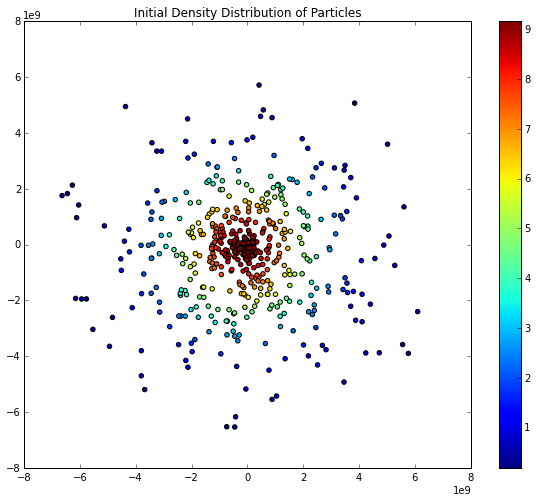

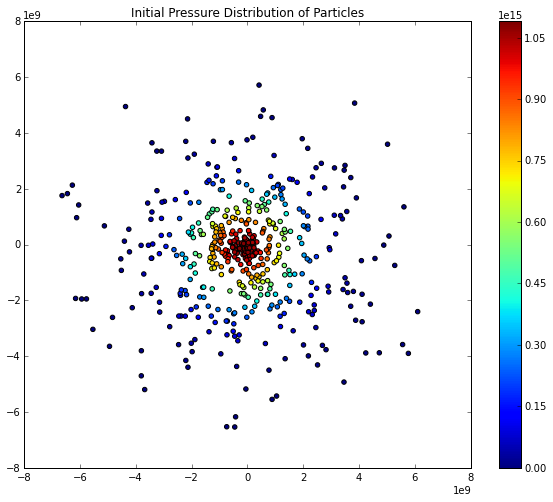

In [19]:
rhoDistribution = np.zeros_like(radiusDistribution)
densityUpdate()
pressureDistribution = K * rhoDistribution ** gamma

# Density plot
plt.figure(figsize=(10,8))
plt.scatter(radiusDistribution*np.cos(thetaDistribution), \
            radiusDistribution*np.sin(thetaDistribution), c=rhoDistribution)
plt.title("Initial Density Distribution of Particles")
plt.colorbar()
plt.show()

# Pressure plot
plt.figure(figsize=(10,8))
plt.scatter(radiusDistribution*np.cos(thetaDistribution), \
            radiusDistribution*np.sin(thetaDistribution), c=pressureDistribution)
plt.title("Initial Pressure Distribution of Particles")
plt.colorbar()
plt.show()

# RK1

In [20]:
# RK1 Parameters
t0 = time.time()
t = 0
dt = 1e2
stepN = 500

# Particle history
ParticlePositionHistory = np.zeros((stepN,nParticles,2))
ParticleRhoHistory = np.zeros((stepN, nParticles, 1))
xyDistributionOld = np.copy(xyDistribution)

# Force history
forceHistory = np.zeros((stepN, 3))

for i in range(stepN):
    if i % 10 == 0:
        print "Time step", i

    deltaVf = np.zeros_like(xyDistribution, dtype = np.float)
    
    t += 1
    ParticlePositionHistory[i,:,:] = xyDistribution
    
    deltaVf += nb_gravity(xyDistribution) 
#    print "\nAvg gravity", np.mean(deltaVf)
    forceHistory[i,0] = np.mean(abs(deltaVf))
    
    deltaVf -= -nb_gradP()/rhoDistribution[:,np.newaxis]
#    print "Avg gravity + pressure", np.mean(deltaVf)
    forceHistory[i,1] = np.mean(abs(deltaVf))

    deltaVf +=  -v*velocityDistribution**1
#    print "Avg damping:", np.mean(velocityDistribution)    
    forceHistory[i,2] = np.mean(-v*abs(velocityDistribution**1))

    
    velocityDistribution += dt*deltaVf    
    xyDistribution += dt*velocityDistribution
    
    densityUpdate()
    ParticleRhoHistory[i,:,:] = rhoDistribution[:,np.newaxis]
    pressureDistribution = K*rhoDistribution**2

print "Total run time:", time.time()-t0


Time step 0
Time step 10
Time step 20
Time step 30
Time step 40
Time step 50
Time step 60
Time step 70
Time step 80
Time step 90
Time step 100
Time step 110
Time step 120
Time step 130
Time step 140
Time step 150
Time step 160
Time step 170
Time step 180
Time step 190
Time step 200
Time step 210
Time step 220
Time step 230
Time step 240
Time step 250
Time step 260
Time step 270
Time step 280
Time step 290
Time step 300
Time step 310
Time step 320
Time step 330
Time step 340
Time step 350
Time step 360
Time step 370
Time step 380
Time step 390
Time step 400
Time step 410
Time step 420
Time step 430
Time step 440
Time step 450
Time step 460
Time step 470
Time step 480
Time step 490
Total run time: 1157.66199994


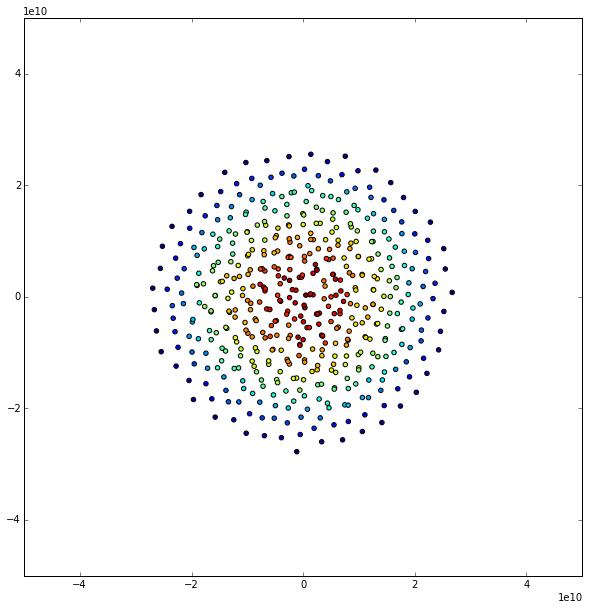

In [21]:
slider = FloatSlider(description='Time', min=1, max=stepN, step=1)

def update_plot():
    time=slider.value
    x = ParticlePositionHistory[time-1,:,0]
    y = ParticlePositionHistory[time-1,:,1]
    fig = plt.figure(figsize=(10,10))
    plt.scatter(x, y, c=ParticleRhoHistory[time-1,:,:])
    plt.xlim(-5e10, 5e10)
    plt.ylim(-5e10, 5e10)
#    plt.colorbar()

    clear_output(True)

slider.on_trait_change(update_plot, 'value')


display(slider)
update_plot()

In [23]:
np.save('2d_equilibrium_position', ParticlePositionHistory)
np.save('2d_equilibrium_density', ParticleRhoHistory)

[]

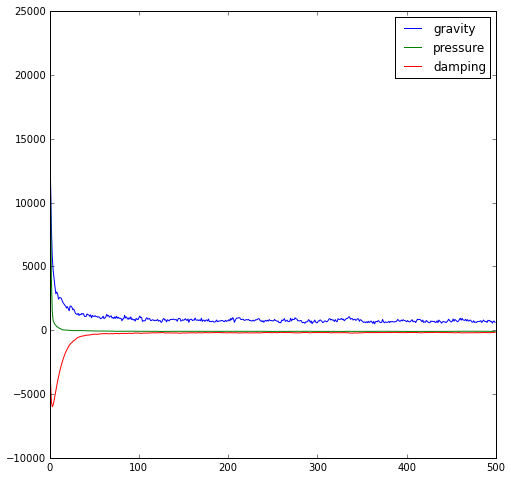

In [22]:
plt.figure(figsize=(8,8))
plt.plot(range(stepN), forceHistory[:,0], label='gravity')
plt.plot(range(stepN), forceHistory[:,1] - forceHistory[:,0], label='pressure')
plt.plot(range(stepN), forceHistory[:,2], label='damping')
#plt.plot(range(stepN), forceHistory[:,1] + forceHistory[:,2], label='net')
#plt.plot(range(stepN), forceHistory[:,1] + forceHistory[:,2], label='net')
plt.legend()
plt.plot()